In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# import Res-IRF
from project.thermal import conventional_heating_final, conventional_energy_3uses, conventional_dhw_final, conventional_heating_need

# Export from ADEME DPE Database

In [8]:
df = pd.read_hdf('input/district_level_diagnosis_data_latest.hdf')
df.set_index('td001_dpe_id', drop=False, inplace=True)
print(df.shape[0])
df.drop_duplicates('td001_dpe_id', inplace=True)
print(df.shape[0])
df.info()

1532140
1448763
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448763 entries, 35 to 5419824
Data columns (total 26 columns):
 #   Column                            Non-Null Count    Dtype   
---  ------                            --------------    -----   
 0   td001_dpe_id                      1448763 non-null  int64   
 1   construction_year_class           1448763 non-null  category
 2   residential_type                  1448763 non-null  category
 3   wall_u_value                      1448763 non-null  category
 4   roof_u_value                      1448763 non-null  category
 5   floor_u_value                     1448763 non-null  category
 6   wall_window_share                 1448763 non-null  category
 7   wall_window_u_value               1448763 non-null  category
 8   wall_window_solar_factor          1448763 non-null  category
 9   roof_window_share                 1448763 non-null  category
 10  roof_window_u_value               1448763 non-null  category
 11  roof_wi

In [10]:
astype = {
    'wall_u_value': 'float',
    'roof_u_value': 'float',
    'floor_u_value': 'float',
    'wall_window_u_value': 'float',
    'main_heating_system_efficiency': 'float',
    'heating_system': 'string'
}

df = df.astype(astype)

heating_system = ['electric heater', 'electric heat pump', 'fossil gas boiler', 'oil boiler', 'biomass/coal boiler']
df = df.loc[df['heating_system'].isin(heating_system), :]

replace = {'[1991, 2005]': '[1991, 2005]',
           '[1971, 1990]': '[1971, 1990]',
           '[1946, 1970]': '[1000, 1970]',
          '[1000, 1918]': '[1000, 1970]',
          '[2006, 2100]': '[2006, 2100]',
          '[1919, 1945]': '[1000, 1970]'
}

df['construction_period'] = df['construction_year_class'].replace(replace)

## Finding U values cluster
U values are continuous variables.
How to group U values to simplify information ?

In [11]:
def replace_closest(data, list_values):
    temp = pd.Series(list_values.values, list_values.values).reindex(data.values, method='nearest')
    temp.index = data.index
    return temp


list_values = {'Wall': pd.Series([2.5, 1, 0.5, 0.4, 0.2, 0.1]),
               'Roof': pd.Series([2.5, 0.5, 0.3, 0.2, 0.1]),
               'Windows': pd.Series([4.3, 3, 2.6, 1.6, 1.3, 0.8]),
               'Floor': pd.Series([2, 0.9, 0.5, 0.3, 0.2])
               }


### Walls

In [12]:
df['wall_u_value'].value_counts() / df['wall_u_value'].value_counts().sum()

0.39    0.333993
2.00    0.323103
0.26    0.090734
0.56    0.071710
0.78    0.071666
1.03    0.069634
1.64    0.039160
Name: wall_u_value, dtype: float64

In [13]:
df['wall_u_value'] = replace_closest(df['wall_u_value'], list_values['Wall'])

In [14]:
temp = df.groupby('construction_period')['wall_u_value'].value_counts().unstack('wall_u_value')
(temp.T / temp.sum(axis=1)).T.sort_index(axis=1, ascending=False)

wall_u_value,2.5,1.0,0.5,0.4,0.2
construction_period,,,,,
"[1000, 1970]",0.546515,0.179483,0.049925,0.166969,0.057108
"[1971, 1990]",0.244623,0.314971,0.106483,0.252400,0.081524
"[1991, 2005]",0.096844,0.013788,0.095274,0.713320,0.080774
"[2006, 2100]",0.088828,0.008589,0.014838,0.645753,0.241992


In [15]:
df['roof_u_value'].value_counts()

0.17    400675
0.29    334135
2.00    282518
0.54    130260
1.23     46854
Name: roof_u_value, dtype: int64

In [16]:
df['roof_u_value'] = replace_closest(df['roof_u_value'], list_values['Roof'])

In [17]:
temp = df.groupby('construction_period')['roof_u_value'].value_counts().unstack('roof_u_value')
(temp.T / temp.sum(axis=1)).T.sort_index(axis=1, ascending=False)

roof_u_value,2.5,0.5,0.3,0.2
construction_period,,,,
"[1000, 1970]",0.356608,0.188836,0.186651,0.267904
"[1971, 1990]",0.183915,0.199224,0.323887,0.292974
"[1991, 2005]",0.129602,0.031373,0.495806,0.343219
"[2006, 2100]",0.121957,0.014639,0.190472,0.672932


In [18]:
df['floor_u_value'].value_counts()

2.00    399099
0.37    318692
0.26    216868
0.60    128733
0.91    100518
1.53     30532
Name: floor_u_value, dtype: int64

In [19]:
df['floor_u_value'] = replace_closest(df['floor_u_value'], list_values['Floor'])

In [20]:
temp = df.groupby('construction_period')['floor_u_value'].value_counts().unstack('floor_u_value')
(temp.T / temp.sum(axis=1)).T.sort_index(axis=1, ascending=False)

floor_u_value,2.0,0.9,0.5,0.3
construction_period,,,,
"[1000, 1970]",0.563327,0.079423,0.034452,0.322798
"[1971, 1990]",0.300187,0.149617,0.176047,0.374149
"[1991, 2005]",0.145157,0.008596,0.214750,0.631497
"[2006, 2100]",0.122149,0.007688,0.021306,0.848857


In [21]:
df['wall_window_u_value'].value_counts()

2.18    465727
2.65    363496
3.20    138743
3.75     94992
1.30     69935
4.61     61549
Name: wall_window_u_value, dtype: int64

In [22]:
df['wall_window_u_value'] = replace_closest(df['wall_window_u_value'], list_values['Windows'])

In [23]:
temp = df.groupby('construction_period')['wall_window_u_value'].value_counts().unstack('wall_window_u_value')
(temp.T / temp.sum(axis=1)).T.sort_index(axis=1, ascending=False)

wall_window_u_value,4.3,3.0,2.6,1.3
construction_period,,,,
"[1000, 1970]",0.183940,0.118451,0.637818,0.059792
"[1971, 1990]",0.150371,0.152529,0.645273,0.051826
"[1991, 2005]",0.039044,0.082551,0.848591,0.029814
"[2006, 2100]",0.015533,0.046648,0.827770,0.110049


## Heating system

In [24]:
df['main_heating_system_efficiency_round'] = df['main_heating_system_efficiency'].copy()

# direct electric
idx = df[df['heating_system'] == 'electric heater'].index
df.loc[idx, 'main_heating_system_efficiency_round'] = 0.95

# fossil boiler
efficiency = pd.Series([0.6, 0.76])
idx = df[df['heating_system'].isin(['fossil gas boiler', 'oil boiler', 'biomass/coal boiler'])].index
temp = pd.Series(efficiency.values, efficiency.values).reindex(df.loc[idx, 'main_heating_system_efficiency'].values, method='nearest')
temp.index = idx
df.loc[idx, 'main_heating_system_efficiency_round'] = temp

# heat pump
idx = df[df['heating_system'] == 'electric heat pump'].index
df.loc[idx, 'main_heating_system_efficiency_round'] = 2.5


### Ventilation system

In [25]:
df['air_change_rate'].unique()

/Users/lucas/opt/anaconda3/envs/APIData/lib/python3.8/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


[0.49, 0.85, 0.66, 0.43, 0.60, 0.76]
Categories (6, float64): [0.43, 0.49, 0.60, 0.66, 0.76, 0.85]

# Calculating energy consumption and DPE based on Res-IRF thermal function

In [26]:
ratio_surface = {'Roof': [0.77, 0.29],
                 'Windows': [0.17, 0.19],
                 'Wall': [1.42, 0.78],
                 'Floor': [0.75, 0.28]
                 }

ratio_surface = pd.DataFrame(ratio_surface, index=pd.Index(['Single-family', 'Multi-family'], name='Housing type'))
ratio_surface

,Roof,Windows,Wall,Floor
Housing type,,,,
Single-family,0.77,0.17,1.42,0.75
Multi-family,0.29,0.19,0.78,0.28


In [27]:
idx = df[df['residential_type'] == 'apartment'].index
df_single = df.loc[idx, :]

In [28]:
vars = {'residential_type': 'Housing type',
        'main_heating_energy': 'Energy',
        'wall_u_value': 'Wall',
        'floor_u_value': 'Floor',
        'roof_u_value': 'Roof',
        'wall_window_u_value': 'Windows',
        'main_heating_system_efficiency_round': 'Efficiency',
        'construction_period': 'Period',
        'air_change_rate': 'Air rate',
        'heating_system': 'Heating system'
        }

buildings = df[vars.keys()].copy()

replace = {'house': 'Single-family',
           'apartment': 'Multi-family',
           'electricity': 'Electricity',
           'oil': 'Oil fuel',
           'fossil_gas': 'Natural gas',
           'biomass': 'Wood fuel',
           'electric heater': 'Electricity-Performance boiler',
          'fossil gas boiler': 'Natural gas-Standard boiler',
          'oil boiler': 'Oil fuel-Standard boiler',
          'biomass/coal boiler': 'Wood fuel-Standard boiler',
          'electric heat pump': 'Electricity-Heat pump'
           }



buildings.loc[:, 'residential_type'] = buildings.loc[:, 'residential_type'].replace(replace)
buildings.loc[:, 'main_heating_energy'] = buildings.loc[:, 'main_heating_energy'].replace(replace)
buildings.loc[:, 'heating_system'] = buildings.loc[:, 'heating_system'].replace(replace)
idx = buildings[buildings['main_heating_system_efficiency_round'] == 0.76].index
buildings.loc[idx, 'heating_system'] = buildings.loc[idx, 'heating_system'].str.replace('Standard', 'Performance')

buildings['air_change_rate'] = buildings['air_change_rate'].astype('float')

buildings = buildings.rename(columns=vars)
buildings = buildings.set_index(['Housing type', 'Energy', 'Heating system'])
buildings


Wall  Floor  Roof  \
Housing type  Energy      Heating system                                      
Single-family Electricity Electricity-Performance boiler   0.4    0.3   0.2   
                          Electricity-Performance boiler   0.2    0.9   0.2   
                          Electricity-Performance boiler   0.4    0.3   0.3   
Multi-family  Electricity Electricity-Performance boiler   0.5    0.3   2.5   
              Natural gas Natural gas-Standard boiler      2.5    0.3   2.5   
...                                                        ...    ...   ...   
                          Natural gas-Performance boiler   1.0    0.5   0.5   
                          Natural gas-Performance boiler   2.5    0.5   0.5   
Single-family Natural gas Natural gas-Standard boiler      2.5    2.0   0.3   
              Electricity Electricity-Performance boiler   0.4    0.3   0.2   
Multi-family  Electricity Electricity-Performance boiler   0.4    2.0   2.5   

                                                          Windows  Efficiency  \
Housing type  Energy      Heating system                                        
Single-family Electricity Electricity-Performance boiler      2.6        0.95   
                          Electricity-Performance boiler      2.6        0.95   
                          Electricity-Performance boiler      2.6        0.95   
Multi-family  Electricity Electricity-Performance boiler      2.6        0.95   
              Natural gas Natural gas-Standard boiler         3.0        0.60   
...                                                           ...         ...   
                          Natural gas-Performance boiler      2.6        0.76   
                          Natural gas-Performance boiler      2.6        0.76   
Single-family Natural gas Natural gas-Standard boiler         2.6        0.60   
              Electricity Electricity-Performance boiler      2.6        0.95   
Multi-family  Electricity Electricity-Performance boiler      2.6        0.95   

                                                                Period  \
Housing type  Energy      Heating system                                 
Single-family Electricity Electricity-Performance boiler  [1991, 2005]   
                          Electricity-Performance boiler  [1971, 1990]   
                          Electricity-Performance boiler  [1991, 2005]   
Multi-family  Electricity Electricity-Performance boiler  [1991, 2005]   
              Natural gas Natural gas-Standard boiler     [1000, 1970]   
...                                                                ...   
                          Natural gas-Performance boiler  [1971, 1990]   
                          Natural gas-Performance boiler  [1971, 1990]   
Single-family Natural gas Natural gas-Standard boiler     [1000, 1970]   
              Electricity Electricity-Performance boiler  [1991, 2005]   
Multi-family  Electricity Electricity-Performance boiler  [1000, 1970]   

                                                          Air rate  
Housing type  Energy      Heating system                            
Single-family Electricity Electricity-Performance boiler      0.49  
                          Electricity-Performance boiler      0.85  
                          Electricity-Performance boiler      0.66  
Multi-family  Electricity Electricity-Performance boiler      0.85  
              Natural gas Natural gas-Standard boiler         0.66  
...                                                            ...  
                          Natural gas-Performance boiler      0.85  
                          Natural gas-Performance boiler      0.66  
Single-family Natural gas Natural gas-Standard boiler         0.60  
              Electricity Electricity-Performance boiler      0.49  
Multi-family  Electricity Electricity-Performance boiler      0.60  

[1194442 rows x 7 columns]

<AxesSubplot: >

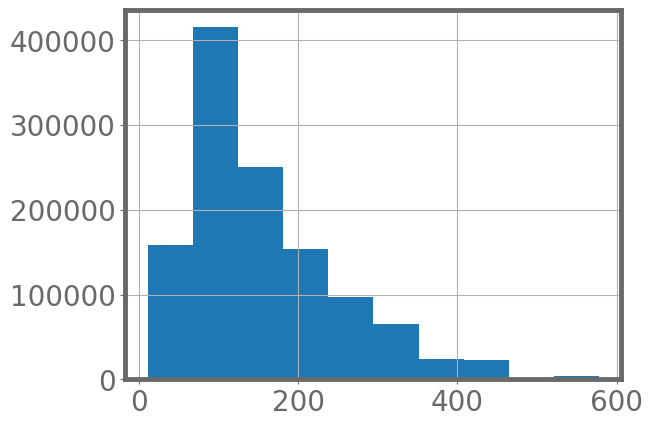

In [29]:
energy = conventional_heating_final(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], ratio_surface, buildings['Efficiency'])
energy.hist()

In [30]:
dpe, energy_primary = conventional_energy_3uses(buildings['Wall'], buildings['Floor'], buildings['Roof'], buildings['Windows'], ratio_surface, buildings['Efficiency'], buildings.index, air_rate=buildings['Air rate'])
result = pd.concat((buildings, dpe.rename('DPE'), energy_primary.rename('PE')), axis=1)
result.set_index('DPE', append=True, inplace=True)
result.head()

TypeError: unsupported operand type(s) for /: 'float' and 'str'

In [ ]:
result.to_csv('data_parsed.csv')